<a href="https://colab.research.google.com/github/nguyen-nhat-mai/sentiment_analysis/blob/main/Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment set up

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 32.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 17.8 MB/s eta 0:00:00


In [6]:
import transformers
from transformers import BertModel, BertTokenizer
import torch
from tqdm import tqdm
import numpy as np
import pandas as pd
from collections import defaultdict
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import lr_scheduler
import torch.nn.functional as F
import random as rn
from random import shuffle
import time, sys
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from wordcloud import WordCloud
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
np.random.seed(17)
rn.seed(12345)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Exploration

In [7]:
def clean_reviews(df):
  # Lowercase & strip
  df[4] = df[4].apply(lambda x: x.lower().strip())
  # Remove punctuation '!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~'
  df[4] = df[4].str.replace('[^\w\s]','')
  # Remove digits
  df[4] = df[4].str.replace('\d+', '')
  # Remove Stopwords
  stop = set(stopwords.words('english'))
  df[4] = df[4].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
  return df

In [16]:
def plot_wordcloud(df, polarity:str, subplot):
  df_pol = df[df[0] == polarity]
  text = " ".join(body_text for body_text in df_pol[4])
  wordcloud = WordCloud(background_color="white").generate(text)
  subplot.imshow(wordcloud, interpolation='bilinear')
  subplot.axis("off")
  subplot.set_title(polarity)

In [40]:
def explore(df):
  # Load and show basic info
  df = clean_reviews(df)
  print("- Data size:", len(df))
  print()
  print("- Top 5 rows of data:")
  print(df.head())
  print()
  # Polarity distribution
  print("- Polarity distribution")
  print(df[0].value_counts())
  print()
  # Aspect distribution
  print("- Aspect distribution")
  print(df[1].value_counts())
  print()
  # Reviews wordcloud
  fig, axs = plt.subplots(1, 3, figsize=(15,5))
  plot_wordcloud(df,'positive',axs[0])
  plot_wordcloud(df,'negative',axs[1])
  plot_wordcloud(df,'neutral',axs[2])
  plt.show()

- Data size: 1503

- Top 5 rows of data:
          0                   1          2       3  \
0  positive    AMBIENCE#GENERAL    seating   18:25   
1  positive    AMBIENCE#GENERAL  trattoria   25:34   
2  positive        FOOD#QUALITY       food  98:102   
3  negative     SERVICE#GENERAL      STAFF    5:10   
4  positive  FOOD#STYLE_OPTIONS       menu     4:8   

                                                   4  
0  short sweet seating greatits romanticcozy private  
1  quaint romantic trattoria top manhattan restau...  
2  different beers offer thier guest made husband...  
3                                        staff fired  
4    menu looked great waiter nice food came average  

- Polarity distribution
positive    1055
negative     390
neutral       58
Name: 0, dtype: int64

- Aspect distribution
FOOD#QUALITY                603
SERVICE#GENERAL             263
AMBIENCE#GENERAL            188
RESTAURANT#GENERAL          138
FOOD#STYLE_OPTIONS           98
FOOD#PRICES            

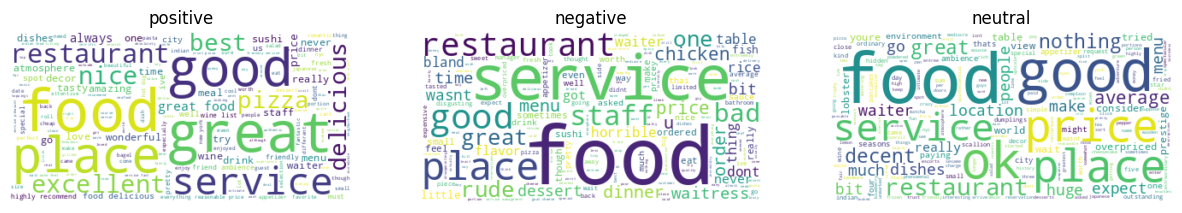

In [41]:
train_df = pd.read_csv('data/traindata.csv', sep='\t', header=None)
explore(train_df)

- Data size: 376

- Top 5 rows of data:
          0                   1             2      3  \
0  positive    LOCATION#GENERAL  neighborhood  54:66   
1  negative  RESTAURANT#GENERAL         place  15:20   
2  positive        FOOD#QUALITY          Fish    0:4   
3  negative     SERVICE#GENERAL       manager  19:26   
4   neutral      DRINKS#QUALITY    margaritas  63:73   

                                                   4  
0  great food great wine list great service great...  
1                    thought place totally overrated  
2                                         fish fresh  
3  showed manager smilingly apologized brought us...  
4  food ordered excellent although wouldnt say ma...  

- Polarity distribution
positive    264
negative     98
neutral      14
Name: 0, dtype: int64

- Aspect distribution
FOOD#QUALITY                163
SERVICE#GENERAL              61
RESTAURANT#GENERAL           47
AMBIENCE#GENERAL             38
FOOD#STYLE_OPTIONS           17
FOOD#PRICES    

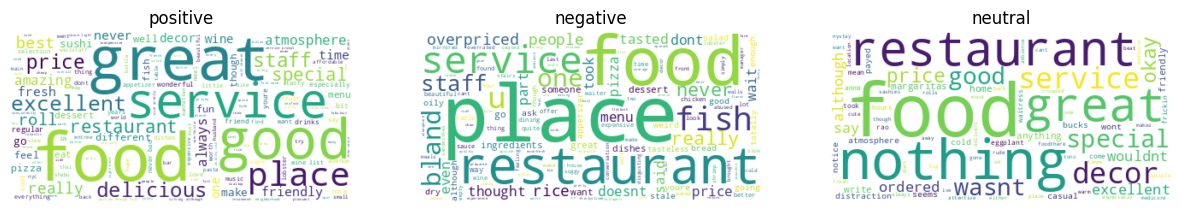

In [42]:
val_df = pd.read_csv('data/devdata.csv', sep='\t', header=None)
explore(val_df)

- Data size: 1879

- Top 5 rows of data:
          0                   1          2       3  \
0  positive    AMBIENCE#GENERAL    seating   18:25   
1  positive    AMBIENCE#GENERAL  trattoria   25:34   
2  positive        FOOD#QUALITY       food  98:102   
3  negative     SERVICE#GENERAL      STAFF    5:10   
4  positive  FOOD#STYLE_OPTIONS       menu     4:8   

                                                   4  
0  short sweet seating greatits romanticcozy private  
1  quaint romantic trattoria top manhattan restau...  
2  different beers offer thier guest made husband...  
3                                        staff fired  
4    menu looked great waiter nice food came average  

- Polarity distribution
positive    1319
negative     488
neutral       72
Name: 0, dtype: int64

- Aspect distribution
FOOD#QUALITY                766
SERVICE#GENERAL             324
AMBIENCE#GENERAL            226
RESTAURANT#GENERAL          185
FOOD#STYLE_OPTIONS          115
FOOD#PRICES            

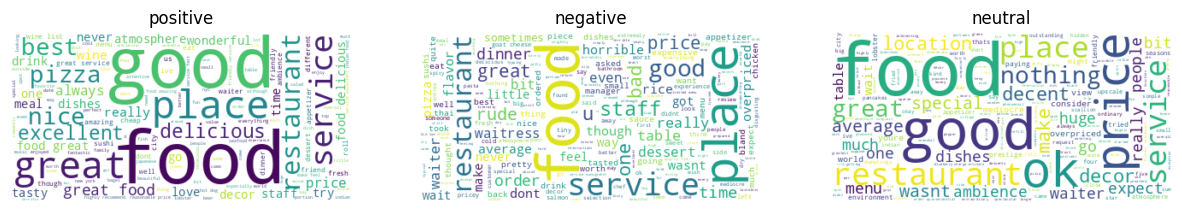

In [46]:
explore(pd.concat([train_df,val_df],ignore_index=True))

## Modeling

In [ ]:
# Network
class SentimentCheck(nn.Module):
    
    def __init__(self, n_classes=3):
        super(SentimentCheck, self).__init__()
        self.model = BertModel.from_pretrained('bert-base-uncased')
        self.drop = nn.Dropout(p=0.45)
        self.fc = nn.Linear(self.model.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        _, output = self.model(input_ids = input_ids, attention_mask = attention_mask)[0:2]
        output = self.drop(output)
        output = self.fc(output)
        return output

In [ ]:
# Preprocessing

#----------------PREPROCESS RAW DATA----------------#
# Converting aspects to questions and consider sentences as replies (account for context)

aspect_map = {"AMBIENCE#GENERAL":"What do you think of the ambience ?",
              "FOOD#QUALITY":"What do you think of the quality of the food ?",
              "SERVICE#GENERAL":"What do you think of the service ?",
              "FOOD#STYLE_OPTIONS": "What do you think of the food choices ?",
              "DRINKS#QUALITY":"What do you think of the drinks?",
              'RESTAURANT#MISCELLANEOUS': "What do you think of the restaurant ?",
              'RESTAURANT#GENERAL': "What do you think of the restaurant ?",
              'LOCATION#GENERAL': 'What do you think of the location ?',
              'DRINKS#STYLE_OPTIONS': "What do you think of the drink choices ?",
              'RESTAURANT#PRICES':'What do you think of the price of it ?',
              'DRINKS#PRICES':'What do you think of the price of it ?',
              'FOOD#PRICES': 'What do you think of the price of it ?'            
              }
label_encode = {"negative":0,"neutral":1,"positive":2}

def preprocessing(file):
    file[0] = file[0].apply(lambda x: label_encode[x])
    file[1] = file[1].apply(lambda x: aspect_map[x])
    return file

#----------------PREPARE PYTORCH DATASET----------------#
# Function to calculate max token length as input for creating pytorch dataset
def max_len_token(file, tokenizer):
    token_lengths = []
    for sentence in file[4]:
        tokens = tokenizer.encode(sentence, max_length=1000)
        token_lengths.append(len(tokens))
    return max(token_lengths)

# Create pytorch dataset
class create_dataset(Dataset):
    
    def __init__(self, sentences, aspect_categories, target_terms, labels, tokenizer, max_len_token):
        
        self.sentences = sentences
        self.aspect_categories = aspect_categories
        self.target_terms = target_terms
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len_token = max_len_token
        
        
    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, index):
        sentence = str(self.sentences[index])
        aspect_category = str(self.aspect_categories[index])
        target_term = str(self.target_terms[index])
        label = self.labels[index]

        aspect = aspect_category + ' ' + target_term
        
        # Get the attention maks
        encoding = self.tokenizer.encode_plus(
            text = sentence,
            text_pair = aspect,
            add_special_tokens=True, # Add '[CLS]' and '[SEP]'
            max_length=self.max_len_token, # Pad & truncate all sentences.
            return_token_type_ids=False,
            pad_to_max_length=True, # Pad to the end of the sentence
            return_attention_mask=True, # Construct attn. masks.
            return_tensors='pt',  # Return PyTorch tensors
            truncation=True)

        return {
            'sentence_text': sentence,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)}

In [ ]:
# Model
class Classifier:
    """
    The Classifier: complete the definition of this class template by providing a constructor (i.e. the
    __init__() function) and the 2 methods train() and predict() below. Please donot change
     """

    ###############################################################################
    def train(self, train_filename: str, dev_filename: str, device: torch.device):
        """
        Trains the classifier model on the training set stored in file trainfile
        PLEASE:
          - DO NOT CHANGE THE SIGNATURE OF THIS METHOD
          - PUT THE MODEL and DATA on the specified device! Do not use another device
          - DO NOT USE THE DEV DATA AS TRAINING EXAMPLES, YOU CAN USE THEM ONLY FOR THE OPTIMIZATION
         OF MODEL HYPERPARAMETERS
        """
        
        #----------------LOAD FILE & PREPROCESS----------------#
        # Load the files into pandas dataframe
        train_file = pd.read_csv(train_filename, sep='\t', header=None)
        if dev_filename is not None:
            dev_file = pd.read_csv(dev_filename, sep='\t', header=None)
        
        # Proprocess the file
        self.trainfile = preprocessing(train_file)
        if dev_filename is not None:
            self.dev_file = preprocessing(dev_file)
        
        #----------------ENCODING & GET DATALOADER------------------#
        # Set the pretrained model & tokenizing
        PRE_TRAINED_MODEL = 'bert-base-uncased'
        self.tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)
        
        # Load the dataloader
        self.bs = 16 # Set batch size
        self.max_length = max_len_token(self.trainfile, self.tokenizer)
        self.train_dataset = create_dataset(
            sentences=self.trainfile[4].to_numpy(),
            aspect_categories = self.trainfile[1].to_numpy(),
            target_terms=self.trainfile[2].to_numpy(),
            labels = self.trainfile[0].to_numpy(),
            tokenizer = self.tokenizer,
            max_len_token = self.max_length)
        self.train_loader = DataLoader(self.train_dataset, batch_size= self.bs, shuffle=True)
        if dev_filename is not None: 
            self.dev_dataset = create_dataset(
                sentences=self.dev_file[4].to_numpy(),
                aspect_categories = self.dev_file[1].to_numpy(),
                target_terms=self.dev_file[2].to_numpy(),
                labels = self.dev_file[0].to_numpy(),
                tokenizer = self.tokenizer,
                max_len_token = self.max_length)
            self.val_loader = DataLoader(self.dev_dataset, batch_size= self.bs, shuffle=True)
            
        #----------------MODEL & HYPEPARAMETERS------------------#
        # Define the devide and the model
        self.device = device
        self.model = SentimentCheck().to(self.device)
    
        # Hyperparameters
        self.epochs = 15
        self.optimizer = optim.Adam(self.model.parameters(), lr=2e-5)
        self.total_steps = len(self.train_loader) * self.epochs
        self.scheduler = lr_scheduler.LinearLR(self.optimizer, total_iters=self.total_steps) # reduce lr gradually to 0
        self.loss_fn = nn.CrossEntropyLoss().to(self.device)
               
        #----------------TRAIN & VALIDATE MODEL------------------#
        record = defaultdict(list)
        best_val_acc = 0
        for epoch in tqdm(range(self.epochs)):
            print()
            print('=' * 10, f'Epoch {epoch + 1}/{self.epochs}', '=' * 10)
            print()
            
            #----------------TRAINING------------------#
            self.model.train()
            losses = []
            correct_predictions = 0
            
            for batch in self.train_loader:
                # Get inputs for model
                input_ids = batch["input_ids"].to(self.device)
                attention_mask = batch["attention_mask"].to(self.device)
                labels = batch["labels"].to(self.device)
                # Predict and calculate loss
                outputs = self.model(input_ids = input_ids, attention_mask = attention_mask)
                _, preds = torch.max(outputs, dim=1)
                loss = self.loss_fn(outputs, labels)
                correct_predictions += torch.sum(preds == labels)
                losses.append(loss.item())
                # Backprop
                loss.backward()
                # Gradient clipping
                nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
                # Take next step
                self.optimizer.step()
                self.scheduler.step()
                
            train_acc, train_loss = correct_predictions.double() / len(self.trainfile), np.mean(losses)        
            print(f'Train loss {train_loss} - Training accuracy {train_acc}')
            print()
            
            #----------------VALIDATION------------------#
            if self.val_loader is not None:
                self.model = self.model.eval()    
                losses = []
                correct_predictions = 0
                
                with torch.no_grad():
                    for batch in self.val_loader:
                        # Get inputs for model
                        input_ids = batch["input_ids"].to(self.device)
                        attention_mask = batch["attention_mask"].to(self.device)
                        labels = batch["labels"].to(self.device)
                        # Predict and calculate loss
                        outputs = self.model(input_ids = input_ids, attention_mask = attention_mask)
                        _, preds = torch.max(outputs, dim=1)
                        loss = self.loss_fn(outputs, labels)
                        correct_predictions += torch.sum(preds == labels)
                        losses.append(loss.item())
                        
                val_acc, val_loss = correct_predictions.double() / len(self.dev_file), np.mean(losses)
                print(f'Val loss {val_loss} - Val accuracy {val_acc}')
                print()
                
            #----------------RECORD ACCURACY & SAVE BEST MODEL------------------#
            record['train_acc'].append(train_acc)
            record['train_loss'].append(train_loss)
                
            if self.val_loader is not None:
                record['val_acc'].append(val_acc)
                record['val_loss'].append(val_loss)
                
            if (self.val_loader is not None) and (val_acc > best_val_acc):
                torch.save(self.model.state_dict(), 'best_model.pth')
                best_val_acc = val_acc
        
    
    ###############################################################################
    def predict(self, data_filename: str, device: torch.device):
        """Predicts class labels for the input instances in file 'datafile'
        Returns the list of predicted labels
        PLEASE:
          - DO NOT CHANGE THE SIGNATURE OF THIS METHOD
          - PUT THE MODEL and DATA on the specified device! Do not use another device
        """
        
        #----------------LOAD FILE & PREPROCESS----------------#
        data_file = pd.read_csv(data_filename, sep='\t', header=None)
        self.data_file = preprocessing(data_file)
        self.dataset = create_dataset(
            sentences=self.data_file[4].to_numpy(),
            aspect_categories = self.data_file[1].to_numpy(),
            target_terms=self.data_file[2].to_numpy(),
            labels = self.data_file[0].to_numpy(),
            tokenizer = self.tokenizer,
            max_len_token = self.max_length)
        self.data_loader = DataLoader(self.dataset, batch_size= self.bs, shuffle=False)
        
        #----------------LOAD MODEL------------------#
        self.device = device
        self.model = SentimentCheck().to(self.device)
        self.model.load_state_dict(torch.load('best_model.pth'))

        #----------------PREDICTING------------------#
        self.model.eval()
        output_labels = []
        label_decode = {0:"negative",1:"neutral",2:"positive"}
        for batch in self.data_loader:
            input_ids = batch["input_ids"].to(self.device)
            attention_mask = batch["attention_mask"].to(self.device)
            labels = batch["labels"].to(self.device)
            with torch.no_grad():
                outputs = self.model(input_ids=input_ids,attention_mask=attention_mask)
            logits = F.softmax(outputs, dim=1)
            logits = logits.detach().cpu().numpy()
            outputs = np.argmax(logits, axis=1) # label in number 0,1,2
            for label in outputs:
                output_labels.append(label_decode[label]) # label in text "negative","neutral","positive"
        return np.array(output_labels)

In [ ]:
# Execute model

def set_reproducible():
    # The below is necessary to have reproducible behavior.
    import random as rn
    import os
    os.environ['PYTHONHASHSEED'] = '0'
    # The below is necessary for starting Numpy generated random numbers
    # in a well-defined initial state.
    np.random.seed(17)
    # The below is necessary for starting core Python generated random numbers
    # in a well-defined state.
    rn.seed(12345)



def load_label_output(filename):
    with open(filename, 'r', encoding='UTF-8') as f:
        return [line.strip().split("\t")[0] for line in f if line.strip()]



def eval_list(glabels, slabels):
    if (len(glabels) != len(slabels)):
        print("\nWARNING: label count in system output (%d) is different from gold label count (%d)\n" % (
        len(slabels), len(glabels)))
    n = min(len(slabels), len(glabels))
    incorrect_count = 0
    for i in range(n):
        if slabels[i] != glabels[i]: incorrect_count += 1
    acc = (n - incorrect_count) / n
    return acc*100



def train_and_eval(classifier, trainfile, devfile, testfile, run_id, device):
    print(f"\nRUN: {run_id}")
    print("  %s.1. Training the classifier..." % str(run_id))
    classifier.train(trainfile, devfile, device)
    print()
    print("  %s.2. Eval on the dev set..." % str(run_id), end="")
    slabels = classifier.predict(devfile, device)
    glabels = load_label_output(devfile)
    devacc = eval_list(glabels, slabels)
    print(" Acc.: %.2f" % devacc)
    testacc = -1
    if testfile is not None:
        # Evaluation on the test data
        print("  %s.3. Eval on the test set..." % str(run_id), end="")
        slabels = classifier.predict(testfile)
        glabels = load_label_output(testfile)
        testacc = eval_list(glabels, slabels)
        print(" Acc.: %.2f" % testacc)
    print()
    return (devacc, testacc)


if __name__ == "__main__":
    device_name = 'cuda'
    device = torch.device(device_name)
    n_runs = 5 #args.n_runs
    set_reproducible()
    datadir = "../data/"
    trainfile =  datadir + "traindata.csv"
    print(trainfile)
    devfile =  datadir + "devdata.csv"
    testfile = None
    # testfile = datadir + "testdata.csv"

    # Runs
    start_time = time.perf_counter()
    devaccs = []
    testaccs = []
    for i in range(1, n_runs+1):
        classifier =  Classifier()
        devacc, testacc = train_and_eval(classifier, trainfile, devfile, testfile, i, device)
        devaccs.append(np.round(devacc,2))
        testaccs.append(np.round(testacc,2))
    print('\nCompleted %d runs.' % n_runs)
    total_exec_time = (time.perf_counter() - start_time)
    print("Dev accs:", devaccs)
    print("Test accs:", testaccs)
    print()
    print("Mean Dev Acc.: %.2f (%.2f)" % (np.mean(devaccs), np.std(devaccs)))
    print("Mean Test Acc.: %.2f (%.2f)" % (np.mean(testaccs), np.std(testaccs)))
    print("\nExec time: %.2f s. ( %d per run )" % (total_exec_time, total_exec_time / n_runs))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


../data/traindata.csv

RUN: 1
  1.1. Training the classifier...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_l


========== Epoch 1/15 ==========

Train loss 0.7451464720862977 - Training accuracy 0.7059214903526281

Val loss 0.5394221792618433 - Val accuracy 0.8138297872340425



  7%|▋         | 1/15 [00:12<02:52, 12.30s/it]


========== Epoch 2/15 ==========

Train loss 0.45461806440924074 - Training accuracy 0.8496340652029275

Val loss 0.3936898075044155 - Val accuracy 0.8563829787234042



 13%|█▎        | 2/15 [00:24<02:40, 12.31s/it]


========== Epoch 3/15 ==========

Train loss 0.3376840125531592 - Training accuracy 0.8848968729208251

Val loss 0.4013814491530259 - Val accuracy 0.8696808510638298



 20%|██        | 3/15 [00:36<02:27, 12.33s/it]


========== Epoch 4/15 ==========

Train loss 0.28719070864880974 - Training accuracy 0.9108449767132402



 27%|██▋       | 4/15 [00:48<02:11, 11.96s/it]

Val loss 0.5534217798461517 - Val accuracy 0.7872340425531915


========== Epoch 5/15 ==========

Train loss 0.2559786610543094 - Training accuracy 0.9161676646706587



 33%|███▎      | 5/15 [00:59<01:57, 11.74s/it]

Val loss 0.5120654584219059 - Val accuracy 0.8484042553191489


========== Epoch 6/15 ==========

Train loss 0.19095594022779705 - Training accuracy 0.9341317365269461



 40%|████      | 6/15 [01:11<01:44, 11.60s/it]

Val loss 0.5704893353395164 - Val accuracy 0.8484042553191489


========== Epoch 7/15 ==========

Train loss 0.1644676976609341 - Training accuracy 0.9500998003992016



 47%|████▋     | 7/15 [01:22<01:32, 11.52s/it]

Val loss 0.5759294821570317 - Val accuracy 0.8537234042553191


========== Epoch 8/15 ==========

Train loss 0.15034985727075725 - Training accuracy 0.957418496340652



 53%|█████▎    | 8/15 [01:33<01:20, 11.46s/it]

Val loss 0.7327674117404968 - Val accuracy 0.8484042553191489


========== Epoch 9/15 ==========

Train loss 0.13353128639356968 - Training accuracy 0.9627411842980705



 60%|██████    | 9/15 [01:45<01:08, 11.44s/it]

Val loss 0.6731476188870147 - Val accuracy 0.8590425531914894


========== Epoch 10/15 ==========

Train loss 0.10937740854012404 - Training accuracy 0.9654025282767797



 67%|██████▋   | 10/15 [01:56<00:57, 11.41s/it]

Val loss 0.7289829888225844 - Val accuracy 0.8537234042553191


========== Epoch 11/15 ==========

Train loss 0.14886896508347064 - Training accuracy 0.9654025282767797



 73%|███████▎  | 11/15 [02:07<00:45, 11.38s/it]

Val loss 1.1120558294157188 - Val accuracy 0.8031914893617021


========== Epoch 12/15 ==========

Train loss 0.11779867312152613 - Training accuracy 0.9687292082501664



 80%|████████  | 12/15 [02:19<00:34, 11.37s/it]

Val loss 0.9247748407894202 - Val accuracy 0.8537234042553191


========== Epoch 13/15 ==========

Train loss 0.0924578438150112 - Training accuracy 0.9747172322022621



 87%|████████▋ | 13/15 [02:30<00:22, 11.36s/it]

Val loss 0.8362694581761995 - Val accuracy 0.8404255319148936


========== Epoch 14/15 ==========

Train loss 0.06420573520479089 - Training accuracy 0.9820359281437125



 93%|█████████▎| 14/15 [02:41<00:11, 11.36s/it]

Val loss 0.6668816726693573 - Val accuracy 0.8484042553191489


========== Epoch 15/15 ==========

Train loss 0.07600634237454135 - Training accuracy 0.9820359281437125



100%|██████████| 15/15 [02:53<00:00, 11.54s/it]

Val loss 0.8271216926708197 - Val accuracy 0.8537234042553191


  1.2. Eval on the dev set...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_length` argument is deprecated and wil

 Acc.: 86.97


RUN: 2
  2.1. Training the classifier...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_l


========== Epoch 1/15 ==========

Train loss 0.6711811386841409 - Training accuracy 0.7511643379906853

Val loss 0.5067118139316639 - Val accuracy 0.8085106382978723



  7%|▋         | 1/15 [00:12<02:53, 12.36s/it]


========== Epoch 2/15 ==========

Train loss 0.42462872674173496 - Training accuracy 0.8689288090485695

Val loss 0.4494043073306481 - Val accuracy 0.8457446808510638



 13%|█▎        | 2/15 [00:24<02:39, 12.30s/it]


========== Epoch 3/15 ==========

Train loss 0.35090896578386743 - Training accuracy 0.888888888888889



 20%|██        | 3/15 [00:35<02:22, 11.86s/it]

Val loss 0.47262899205088615 - Val accuracy 0.8351063829787234


========== Epoch 4/15 ==========

Train loss 0.3017202211900594 - Training accuracy 0.9055222887558217

Val loss 0.4978406199564536 - Val accuracy 0.8484042553191489



 27%|██▋       | 4/15 [00:48<02:12, 12.02s/it]


========== Epoch 5/15 ==========

Train loss 0.276034267024791 - Training accuracy 0.9155023286759814



 33%|███▎      | 5/15 [00:59<01:57, 11.77s/it]

Val loss 0.5635853223502636 - Val accuracy 0.8271276595744681


========== Epoch 6/15 ==========

Train loss 0.22944982252777257 - Training accuracy 0.9248170326014638



 40%|████      | 6/15 [01:10<01:44, 11.62s/it]

Val loss 0.5527800557514032 - Val accuracy 0.8351063829787234


========== Epoch 7/15 ==========

Train loss 0.20063869242972515 - Training accuracy 0.9308050565535596



 47%|████▋     | 7/15 [01:22<01:32, 11.52s/it]

Val loss 0.6294241192129751 - Val accuracy 0.8297872340425532


========== Epoch 8/15 ==========

Train loss 0.1530348434400289 - Training accuracy 0.9520958083832336



 53%|█████▎    | 8/15 [01:33<01:20, 11.47s/it]

Val loss 0.6079216750028232 - Val accuracy 0.8430851063829787


========== Epoch 9/15 ==========

Train loss 0.1478626601883468 - Training accuracy 0.957418496340652

Val loss 0.622757780055205 - Val accuracy 0.8563829787234042



 60%|██████    | 9/15 [01:45<01:10, 11.72s/it]


========== Epoch 10/15 ==========

Train loss 0.11269146341216216 - Training accuracy 0.9673985362608117

Val loss 0.5803188468174388 - Val accuracy 0.8590425531914894



 67%|██████▋   | 10/15 [01:58<00:59, 11.88s/it]


========== Epoch 11/15 ==========

Train loss 0.11610132248012071 - Training accuracy 0.9660678642714571



 73%|███████▎  | 11/15 [02:09<00:46, 11.71s/it]

Val loss 0.7397136048724254 - Val accuracy 0.8430851063829787


========== Epoch 12/15 ==========

Train loss 0.09736690308745118 - Training accuracy 0.9727212242182303



 80%|████████  | 12/15 [02:20<00:34, 11.60s/it]

Val loss 0.855380897099773 - Val accuracy 0.8537234042553191


========== Epoch 13/15 ==========

Train loss 0.11455290974241662 - Training accuracy 0.9713905522288756



 87%|████████▋ | 13/15 [02:32<00:23, 11.52s/it]

Val loss 0.8477886735927314 - Val accuracy 0.8430851063829787


========== Epoch 14/15 ==========

Train loss 0.10399122822204941 - Training accuracy 0.9740518962075848

Val loss 0.8090848625724902 - Val accuracy 0.8643617021276595



 93%|█████████▎| 14/15 [02:44<00:11, 11.74s/it]


========== Epoch 15/15 ==========

Train loss 0.07842103346805782 - Training accuracy 0.9773785761809715



100%|██████████| 15/15 [02:55<00:00, 11.71s/it]

Val loss 0.8865578463883139 - Val accuracy 0.8537234042553191


  2.2. Eval on the dev set...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_length` argument is deprecated and wil

 Acc.: 86.44


RUN: 3
  3.1. Training the classifier...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_l


========== Epoch 1/15 ==========

Train loss 0.678602361615668 - Training accuracy 0.7458416500332669

Val loss 0.4596155422429244 - Val accuracy 0.8457446808510638



  7%|▋         | 1/15 [00:12<02:52, 12.31s/it]


========== Epoch 2/15 ==========

Train loss 0.4187905813785309 - Training accuracy 0.8709248170326015

Val loss 0.44560410113384324 - Val accuracy 0.8484042553191489



 13%|█▎        | 2/15 [00:24<02:39, 12.28s/it]


========== Epoch 3/15 ==========

Train loss 0.35063146038892423 - Training accuracy 0.8915502328675982



 20%|██        | 3/15 [00:35<02:22, 11.86s/it]

Val loss 0.45867781682560843 - Val accuracy 0.8377659574468085


========== Epoch 4/15 ==========

Train loss 0.30729878975197356 - Training accuracy 0.908183632734531

Val loss 0.4842602907059093 - Val accuracy 0.851063829787234



 27%|██▋       | 4/15 [00:48<02:12, 12.03s/it]


========== Epoch 5/15 ==========

Train loss 0.26998945892332715 - Training accuracy 0.9155023286759814



 33%|███▎      | 5/15 [00:59<01:57, 11.78s/it]

Val loss 0.5610004474098483 - Val accuracy 0.8404255319148936


========== Epoch 6/15 ==========

Train loss 0.236819463890997 - Training accuracy 0.9254823685961411

Val loss 0.5654406735363106 - Val accuracy 0.8563829787234042



 40%|████      | 6/15 [01:11<01:47, 11.94s/it]


========== Epoch 7/15 ==========

Train loss 0.20048869868859331 - Training accuracy 0.9394544244843647



 47%|████▋     | 7/15 [01:23<01:33, 11.74s/it]

Val loss 0.5649616441999873 - Val accuracy 0.8457446808510638


========== Epoch 8/15 ==========

Train loss 0.1521600273913367 - Training accuracy 0.9540918163672655



 53%|█████▎    | 8/15 [01:34<01:21, 11.62s/it]

Val loss 0.624512090968589 - Val accuracy 0.8563829787234042


========== Epoch 9/15 ==========

Train loss 0.15278496605621533 - Training accuracy 0.9580838323353293

Val loss 0.5789396949888518 - Val accuracy 0.8670212765957447



 60%|██████    | 9/15 [01:46<01:10, 11.83s/it]


========== Epoch 10/15 ==========

Train loss 0.1352622543803436 - Training accuracy 0.9627411842980705



 67%|██████▋   | 10/15 [01:58<00:58, 11.68s/it]

Val loss 0.801596310241924 - Val accuracy 0.8457446808510638


========== Epoch 11/15 ==========

Train loss 0.13469955928752475 - Training accuracy 0.9620758483033932



 73%|███████▎  | 11/15 [02:09<00:46, 11.58s/it]

Val loss 0.8539499013374249 - Val accuracy 0.8430851063829787


========== Epoch 12/15 ==========

Train loss 0.12588786179363293 - Training accuracy 0.9667332002661344



 80%|████████  | 12/15 [02:20<00:34, 11.51s/it]

Val loss 0.7461864253079208 - Val accuracy 0.8537234042553191


========== Epoch 13/15 ==========

Train loss 0.12555925369738263 - Training accuracy 0.9693945442448436



 87%|████████▋ | 13/15 [02:32<00:22, 11.46s/it]

Val loss 0.7981744071294088 - Val accuracy 0.851063829787234


========== Epoch 14/15 ==========

Train loss 0.11080411756832272 - Training accuracy 0.9760479041916168



 93%|█████████▎| 14/15 [02:43<00:11, 11.43s/it]

Val loss 0.8241718835003363 - Val accuracy 0.851063829787234


========== Epoch 15/15 ==========

Train loss 0.11938948921507542 - Training accuracy 0.9753825681969395



100%|██████████| 15/15 [02:54<00:00, 11.66s/it]

Val loss 0.7836572881496977 - Val accuracy 0.8590425531914894


  3.2. Eval on the dev set...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_length` argument is deprecated and wil

 Acc.: 86.70


RUN: 4
  4.1. Training the classifier...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_l


========== Epoch 1/15 ==========

Train loss 0.7469641661390345 - Training accuracy 0.7005988023952096

Val loss 0.5071849388380846 - Val accuracy 0.8324468085106382



  7%|▋         | 1/15 [00:12<02:52, 12.29s/it]


========== Epoch 2/15 ==========

Train loss 0.43564521275619245 - Training accuracy 0.8449767132401863

Val loss 0.43534870631992817 - Val accuracy 0.8377659574468085



 13%|█▎        | 2/15 [00:24<02:39, 12.27s/it]


========== Epoch 3/15 ==========

Train loss 0.33019673313073655 - Training accuracy 0.8942115768463074

Val loss 0.45334448851644993 - Val accuracy 0.8723404255319148



 20%|██        | 3/15 [00:36<02:27, 12.27s/it]


========== Epoch 4/15 ==========

Train loss 0.2767781622390798 - Training accuracy 0.9041916167664671



 27%|██▋       | 4/15 [00:48<02:11, 11.93s/it]

Val loss 0.49637737528731424 - Val accuracy 0.8484042553191489


========== Epoch 5/15 ==========

Train loss 0.228837531674257 - Training accuracy 0.9261477045908184



 33%|███▎      | 5/15 [00:59<01:57, 11.72s/it]

Val loss 0.5728680519387126 - Val accuracy 0.8457446808510638


========== Epoch 6/15 ==========

Train loss 0.21832916891559007 - Training accuracy 0.936127744510978



 40%|████      | 6/15 [01:10<01:44, 11.59s/it]

Val loss 0.47288419826266664 - Val accuracy 0.8457446808510638


========== Epoch 7/15 ==========

Train loss 0.17187477390162964 - Training accuracy 0.9467731204258151



 47%|████▋     | 7/15 [01:22<01:31, 11.50s/it]

Val loss 0.5288364583199533 - Val accuracy 0.8484042553191489


========== Epoch 8/15 ==========

Train loss 0.14391735519104182 - Training accuracy 0.959414504324684



 53%|█████▎    | 8/15 [01:33<01:20, 11.44s/it]

Val loss 0.5921021970376993 - Val accuracy 0.851063829787234


========== Epoch 9/15 ==========

Train loss 0.11675339831940909 - Training accuracy 0.9654025282767797



 60%|██████    | 9/15 [01:44<01:08, 11.42s/it]

Val loss 0.8102335308988889 - Val accuracy 0.8297872340425532


========== Epoch 10/15 ==========

Train loss 0.11085688747946133 - Training accuracy 0.9680638722554891



 67%|██████▋   | 10/15 [01:56<00:56, 11.39s/it]

Val loss 0.8408653390749047 - Val accuracy 0.8430851063829787


========== Epoch 11/15 ==========

Train loss 0.10592497992477914 - Training accuracy 0.9727212242182303



 73%|███████▎  | 11/15 [02:07<00:45, 11.37s/it]

Val loss 0.9251106303369548 - Val accuracy 0.8484042553191489


========== Epoch 12/15 ==========

Train loss 0.1550832996454506 - Training accuracy 0.9667332002661344



 80%|████████  | 12/15 [02:18<00:34, 11.36s/it]

Val loss 0.822391099393523 - Val accuracy 0.8457446808510638


========== Epoch 13/15 ==========

Train loss 0.09592232049784642 - Training accuracy 0.9747172322022621



 87%|████████▋ | 13/15 [02:30<00:22, 11.35s/it]

Val loss 0.9517057842798143 - Val accuracy 0.8244680851063829


========== Epoch 14/15 ==========

Train loss 0.10816941365285063 - Training accuracy 0.9740518962075848



 93%|█████████▎| 14/15 [02:41<00:11, 11.35s/it]

Val loss 0.7783531164944483 - Val accuracy 0.8457446808510638


========== Epoch 15/15 ==========

Train loss 0.10448789904129374 - Training accuracy 0.9747172322022621



100%|██████████| 15/15 [02:52<00:00, 11.53s/it]

Val loss 1.0475289700552821 - Val accuracy 0.8297872340425532


  4.2. Eval on the dev set...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_length` argument is deprecated and wil

 Acc.: 87.23


RUN: 5
  5.1. Training the classifier...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|          | 0/15 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_l


========== Epoch 1/15 ==========

Train loss 0.7026962216230149 - Training accuracy 0.7232202262142382

Val loss 0.44756957453986007 - Val accuracy 0.8457446808510638



  7%|▋         | 1/15 [00:12<02:52, 12.29s/it]


========== Epoch 2/15 ==========

Train loss 0.40509676188230515 - Training accuracy 0.8616101131071191



 13%|█▎        | 2/15 [00:23<02:32, 11.74s/it]

Val loss 0.4101928590486447 - Val accuracy 0.8404255319148936


========== Epoch 3/15 ==========

Train loss 0.31542681997760813 - Training accuracy 0.9001996007984032

Val loss 0.4050348731689155 - Val accuracy 0.8882978723404256



 20%|██        | 3/15 [00:35<02:23, 11.97s/it]


========== Epoch 4/15 ==========

Train loss 0.26846448338015916 - Training accuracy 0.9115103127079175



 27%|██▋       | 4/15 [00:47<02:09, 11.73s/it]

Val loss 0.44008215943661827 - Val accuracy 0.8590425531914894


========== Epoch 5/15 ==========

Train loss 0.20949657570491445 - Training accuracy 0.927478376580173



 33%|███▎      | 5/15 [00:58<01:55, 11.59s/it]

Val loss 0.6285092948625485 - Val accuracy 0.8430851063829787


========== Epoch 6/15 ==========

Train loss 0.20875765971760166 - Training accuracy 0.936127744510978



 40%|████      | 6/15 [01:09<01:43, 11.50s/it]

Val loss 0.6026292233727872 - Val accuracy 0.8377659574468085


========== Epoch 7/15 ==========

Train loss 0.17055669174767396 - Training accuracy 0.9534264803725881



 47%|████▋     | 7/15 [01:21<01:31, 11.45s/it]

Val loss 0.5953699523427834 - Val accuracy 0.8484042553191489


========== Epoch 8/15 ==========

Train loss 0.13580399049951278 - Training accuracy 0.9620758483033932



 53%|█████▎    | 8/15 [01:32<01:19, 11.41s/it]

Val loss 0.5355156695780655 - Val accuracy 0.875


========== Epoch 9/15 ==========

Train loss 0.10505442375049709 - Training accuracy 0.9687292082501664



 60%|██████    | 9/15 [01:43<01:08, 11.38s/it]

Val loss 0.6582490552294379 - Val accuracy 0.8590425531914894


========== Epoch 10/15 ==========

Train loss 0.1002427960691498 - Training accuracy 0.9727212242182303



 67%|██████▋   | 10/15 [01:55<00:56, 11.37s/it]

Val loss 0.721562508008598 - Val accuracy 0.8643617021276595


========== Epoch 11/15 ==========

Train loss 0.08360814849197111 - Training accuracy 0.9740518962075848



 73%|███████▎  | 11/15 [02:06<00:45, 11.36s/it]

Val loss 1.0508884990413208 - Val accuracy 0.7845744680851063


========== Epoch 12/15 ==========

Train loss 0.10950984047822397 - Training accuracy 0.9740518962075848



 80%|████████  | 12/15 [02:17<00:34, 11.36s/it]

Val loss 0.857340856838467 - Val accuracy 0.8404255319148936


========== Epoch 13/15 ==========

Train loss 0.13825690258168022 - Training accuracy 0.9647371922821025



 87%|████████▋ | 13/15 [02:29<00:22, 11.36s/it]

Val loss 0.726646188646555 - Val accuracy 0.8324468085106382


========== Epoch 14/15 ==========

Train loss 0.10091370135419407 - Training accuracy 0.9767132401862941



 93%|█████████▎| 14/15 [02:40<00:11, 11.37s/it]

Val loss 0.8733855766137518 - Val accuracy 0.8457446808510638


========== Epoch 15/15 ==========

Train loss 0.11742894566541122 - Training accuracy 0.9753825681969395



100%|██████████| 15/15 [02:52<00:00, 11.47s/it]

Val loss 1.058729358536463 - Val accuracy 0.8351063829787234


  5.2. Eval on the dev set...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.9/dist-packages/transformers/tokenization_utils_base.py:2302: FutureWarning: The `pad_to_max_length` argument is deprecated and wil

 Acc.: 88.83


Completed 5 runs.
Dev accs: [86.97, 86.44, 86.7, 87.23, 88.83]
Test accs: [-1, -1, -1, -1, -1]

Mean Dev Acc.: 87.23 (0.84)
Mean Test Acc.: -1.00 (0.00)

Exec time: 892.20 s. ( 178 per run )
